In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import networkx as nx
import json
import numpy as np
from datetime import date
from textblob import TextBlob

time: 0 ns


In [103]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns


In [104]:
path = r'D:\Yelp\yelp_academic_dataset_review.json'

time: 0 ns


In [105]:
data = []
for index, line in enumerate(open(path, 'r', encoding="utf-8")):
    if index == 10000:
        break
    data.append(json.loads(line))

time: 235 ms


In [106]:
df = pd.DataFrame(data)

time: 31 ms


In [107]:
def find_cliques(G, n):
    #cliques = list(nx.enumerate_all_cliques(G))
    result = []
    cliques = list(nx.find_cliques(G))
    for clique in cliques:
        if len(clique) > n:
            result.append(clique)
        
        
    print(len(result))
    return result

time: 0 ns


In [108]:
def add_sentiment(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    #subjectivity = testimonial.sentiment.subjectivity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    elif polarity == 0:
        sentiment = 'neutral'
    
    return sentiment 

time: 0 ns


In [109]:
def duration(row):
    amin = row.date.amin
    amin = amin.split('-')
    year_amin = int(amin[0])
    month_amin = int(amin[1])
    day_amin = int(amin[2][:2])
    
    amax = row.date.amax
    amax = amax.split('-')
    year_amax = int(amax[0])
    month_amax = int(amax[1])
    day_amax = int(amax[2][:2])
    
    d0 = date(year_amax, month_amax, day_amax)
    d1 = date(year_amin, month_amin, day_amin)
    delta = d1 - d0
    
    return abs(delta.days) 
    

time: 16 ms


In [110]:
def add_text_len(text):
    return len(text)

time: 0 ns


In [111]:
df['sentiment'] = np.vectorize(add_sentiment)(df['text'])
df['len_text'] = np.vectorize(add_text_len)(df['text'])

time: 13.6 s


In [112]:
df.shape

(10000, 11)

time: 0 ns


In [113]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'sentiment', 'len_text'],
      dtype='object')

time: 31 ms


In [114]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,len_text
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,positive,1373
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,negative,1407
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,positive,431
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,negative,401
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,positive,841


time: 16 ms


In [115]:
G = nx.Graph()

time: 0 ns


In [116]:
groups = df.groupby('business_id')

time: 0 ns


In [117]:
users = []
for index, g in groups:
    _users = g.user_id.values
    sentiments = g.sentiment.values
    result = []
    
    for i in range(len(_users)):
        if sentiments[i] == 'negative':
            result.append(_users[i])
    
    if len(result) > 1:
        users.append(result)
print(len(users))

169
time: 938 ms


In [118]:
for _users in users:
    edges = list(set(itertools.permutations(_users, 2)))
    for e in edges:
        u = e[0]
        v = e[1]
        G.add_edge(u, v) 

time: 0 ns


In [119]:
cliques = find_cliques(G, 1)

167
time: 16 ms


In [120]:
groups_dict = []
for index, group in enumerate(cliques):
    if len(group) > 1:
        if len(group) < 1000 :
            for user in group:
                groups_dict.append({'user_id': user, 'group_len': len(group), 'group_id': index})

time: 0 ns


In [121]:
df_groups = pd.DataFrame(groups_dict)

time: 0 ns


In [122]:
df = df.merge(df_groups, on=['user_id'], how='outer')

time: 16 ms


In [123]:
df = df.fillna(0)

time: 0 ns


In [124]:
df_time = df.groupby('group_id').agg({'date': [np.min,np.max]})

time: 125 ms


In [125]:
df_time['duration'] = df_time.apply(lambda row: duration(row), axis=1)

time: 141 ms


In [126]:
df = df.merge(df_time.duration, on=['group_id'], how='outer')

time: 47 ms


In [127]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,len_text,group_len,group_id,duration
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,positive,1373,0.0,0.0,5001
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,negative,1407,0.0,0.0,5001
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,positive,431,0.0,0.0,5001
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,negative,401,0.0,0.0,5001
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,positive,841,0.0,0.0,5001


time: 16 ms


---

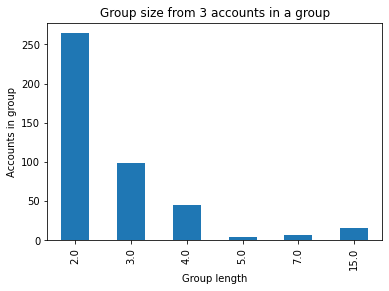

time: 156 ms


In [128]:
df.group_len.value_counts()[2:].sort_index().plot(title='Group size from 3 accounts in a group', kind='bar')
plt.xlabel('Group length')
plt.ylabel('Accounts in group')
plt.show()

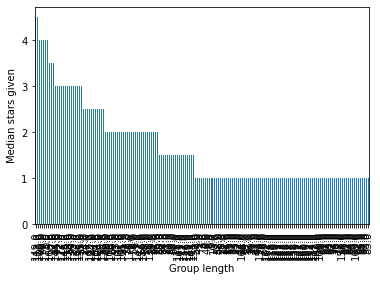

time: 2.52 s


In [129]:
df.groupby('group_id').stars.median().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Group length')
plt.ylabel('Median stars given')
plt.show()

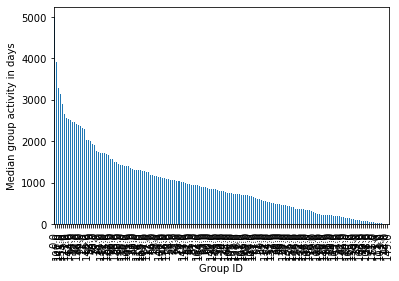

time: 2.25 s


In [130]:
df.groupby('group_id').duration.median().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Group ID')
plt.ylabel('Median group activity in days')
plt.show()

<AxesSubplot:xlabel='group_id'>

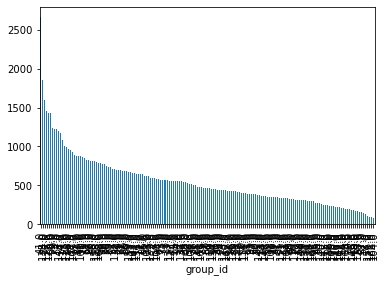

time: 2.84 s


In [131]:
df.groupby('group_id').len_text.median().sort_values(ascending=False).plot(kind='bar')